In [1]:
import numpy as np
from nltk.stem import *
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
import nltk

## Metricas IR

In [2]:
def precision(relevance_arr: np.array) -> float:
    return np.mean(relevance_arr)


def precision_at_k(relevance_arr: np.array, k: int) -> float:
    return np.mean(relevance_arr[0:k])


def recall_at_k(relevance_arr: np.array, number_relevant_doc: int, k: int) -> float:
    return relevance_arr[0:k].sum() / number_relevant_doc


def average_precision(relevance_arr: np.array):
    """Calcula la presicion promedio, recuerda que solo se calcula donde
    hay documentos relevantes

    Args:
        relevance_arr (np.array): _description_

    Returns:
        _type_: _description_
    """

    precisiones = [
        precision_at_k(relevance_arr, k + 1)
        for k in range(len(relevance_arr))
        if relevance_arr[k] == 1
    ]
    if len(precisiones) == 0:
        return np.float64(0)
    else:
        return np.mean(precisiones)


def mean_average_precision(querys_matrix: np.ndarray) -> float:

    # scores = [average_precision(querys_matrix) for row in querys_matrix]
    querys_matrix = np.array(querys_matrix, dtype=object)
    arr_result = np.zeros(len(querys_matrix))
    for i, row in enumerate(querys_matrix):
        arr_result[i] = average_precision(row)  # cada row puede tener tamaño distinto
    return np.mean(arr_result)


def dct_at_one_k(relevance_arr: np.array, k: int) -> float:

    gain = np.sum(relevance_arr)
    discount_factor = np.log2(max(k, 2))
    return gain / discount_factor


def dcg_at_k(relevance_arr: np.array, k: int) -> float:
    expected2 = [
        value / np.log2(max(2, i + 1)) for i, value in enumerate(relevance_arr[:k])
    ]
    expected2 = np.sum(expected2)

    return expected2


def ndcg_at_k(relevance_arr: np.array, k: int) -> float:
    dcg = dcg_at_k(relevance_arr, k)
    ideal_dcg = dcg_at_k(sorted(relevance_arr, reverse=True), k)
    return dcg / ideal_dcg


# TODO faltan las pruebas

In [3]:
dct_at_one_k([1, 0, 0], 3)

np.float64(0.6309297535714575)

In [4]:
# Pruebas


def test_precision():
    assert precision(np.array([0, 0, 0, 1])) == np.float64(0.25)
    assert precision(np.array([1, 1, 1, 1])) == np.float64(1.0)
    assert precision(np.array([0, 0, 0, 0])) == np.float64(0.0)
    assert precision(np.array([1, 0, 1, 0])) == np.float64(0.5)


def test_precision_at_k():
    assert precision_at_k(np.array([0, 0, 0, 1]), 2) == np.float64(0.0)
    assert precision_at_k(np.array([1, 1, 1, 1]), 2) == np.float64(1.0)
    assert precision_at_k(np.array([1, 0, 1, 0]), 2) == np.float64(0.5)
    assert precision_at_k(np.array([1, 0, 1, 0]), 3) == np.float64(2 / 3)


def test_recall_at_k():
    arr = np.array([0, 0, 0, 1])
    assert recall_at_k(arr, number_relevant_doc=1, k=2) == 0.0
    assert recall_at_k(arr, number_relevant_doc=1, k=4) == 1.0
    assert recall_at_k(arr, number_relevant_doc=4, k=1) == 0

    arr = np.array([1, 1, 1, 1])
    assert recall_at_k(arr, number_relevant_doc=4, k=2) == 0.5
    assert recall_at_k(arr, number_relevant_doc=4, k=4) == 1.0

    arr = np.array([1, 0, 1, 0])
    assert recall_at_k(arr, number_relevant_doc=2, k=2) == 0.5
    assert recall_at_k(arr, number_relevant_doc=2, k=3) == 1.0


def test_average_precision():

    relevance_query_2 = [0, 1, 0, 1, 1, 1, 1]
    result = average_precision(relevance_query_2)
    assert np.isclose(result, 0.5961904, atol=1e-6)

    relevance_all = [1, 1, 1, 1]
    assert average_precision(relevance_all) == 1.0

    relevance_none = [0, 0, 0, 0]
    assert average_precision(relevance_none) == 0.0

    relevance_last = [0, 0, 0, 1]
    assert average_precision(relevance_last) == 0.25


def test_mean_average_precision():
    querys_matrix = np.array(
        [[0, 1, 0, 1, 1, 1, 1], [1, 1, 1, 1], [0, 0, 0, 0], [0, 0, 0, 1]], dtype=object
    )

    result = mean_average_precision(querys_matrix)
    expected = np.mean([0.5961904, 1.0, 0.0, 0.25])
    assert np.isclose(result, expected, atol=1e-6)
    querys_matrix = [
        [0, 1, 0, 1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1],
    ]
    result = mean_average_precision(querys_matrix)
    assert np.isclose(result, np.float64(0.471964285714), atol=1e-6)


def test_dcg_at_k():
    rels1 = np.array([1, 1, 1, 1])
    expected1 = 1 / 1 + 1 / 1 + 1 / np.log2(3) + 1 / np.log2(4)
    assert np.isclose(dcg_at_k(rels1, 4), expected1, atol=1e-6)

    rels2 = np.array([1, 0, 0, 0])
    expected1 = 1 / np.log2(2) + 0 / np.log2(2) + 0 / np.log2(3) + 0 / np.log2(4)
    assert np.isclose(dcg_at_k(rels2, 4), 1.0, atol=1e-6)

    rels3 = np.array([3, 2, 3, 0, 1])
    expected3 = 3 / np.log2(2) + 2 / np.log2(2) + 3 / np.log2(3) + 0 + 1 / np.log2(5)
    assert np.isclose(dcg_at_k(rels3, 5), expected3, atol=1e-6)


def test_ndcg_at_k():
    rels1 = np.array([1, 1, 1, 1])
    assert np.isclose(ndcg_at_k(rels1, 4), 1.0, atol=1e-6)

    rels2 = np.array([1, 0, 0, 0])
    assert np.isclose(ndcg_at_k(rels2, 4), 1.0, atol=1e-6)

    rels3 = np.array([3, 2, 3, 0, 1])
    dcg = dcg_at_k(rels3, 5)
    idcg = dcg_at_k(np.sort(rels3)[::-1], 5)
    expected_ndcg = dcg / idcg
    assert np.isclose(ndcg_at_k(rels3, 5), expected_ndcg, atol=1e-6)


test_precision()
print("Se paso la prueba de precision")
test_precision_at_k()
print("Se paso la prueba de precision at k")
test_recall_at_k()
print("Se paso la prueba de recall at k")
test_average_precision()
print("se paso la prueba de average precision")
test_mean_average_precision()
print("Se paso el test de mean average precision")
test_dcg_at_k()
print("Se paso la prueba de dcg_at_k")
test_ndcg_at_k()
print("Se paso la prueba de n_dcg_at_k")

Se paso la prueba de precision
Se paso la prueba de precision at k
Se paso la prueba de recall at k
se paso la prueba de average precision
Se paso el test de mean average precision
Se paso la prueba de dcg_at_k
Se paso la prueba de n_dcg_at_k


## Parte 2: Comparacion de estrategias de motores de busqueda

In [5]:
import xml.etree.ElementTree as ET
import os
from nltk.corpus import stopwords

Docs

In [6]:
list_docs_files = sorted(os.listdir("./data/docs-raw-texts/"))

In [7]:
list_docs_files

['wes2015.d001.naf',
 'wes2015.d002.naf',
 'wes2015.d003.naf',
 'wes2015.d004.naf',
 'wes2015.d005.naf',
 'wes2015.d006.naf',
 'wes2015.d007.naf',
 'wes2015.d008.naf',
 'wes2015.d009.naf',
 'wes2015.d010.naf',
 'wes2015.d011.naf',
 'wes2015.d012.naf',
 'wes2015.d013.naf',
 'wes2015.d014.naf',
 'wes2015.d015.naf',
 'wes2015.d016.naf',
 'wes2015.d017.naf',
 'wes2015.d018.naf',
 'wes2015.d019.naf',
 'wes2015.d020.naf',
 'wes2015.d021.naf',
 'wes2015.d022.naf',
 'wes2015.d023.naf',
 'wes2015.d024.naf',
 'wes2015.d025.naf',
 'wes2015.d026.naf',
 'wes2015.d027.naf',
 'wes2015.d028.naf',
 'wes2015.d029.naf',
 'wes2015.d030.naf',
 'wes2015.d031.naf',
 'wes2015.d032.naf',
 'wes2015.d033.naf',
 'wes2015.d034.naf',
 'wes2015.d035.naf',
 'wes2015.d036.naf',
 'wes2015.d037.naf',
 'wes2015.d038.naf',
 'wes2015.d039.naf',
 'wes2015.d040.naf',
 'wes2015.d041.naf',
 'wes2015.d042.naf',
 'wes2015.d043.naf',
 'wes2015.d044.naf',
 'wes2015.d045.naf',
 'wes2015.d046.naf',
 'wes2015.d047.naf',
 'wes2015.d04

In [ ]:
# nltk_stop_words_en = set(
#     nltk.corpus.stopwords.words("english")
# )  # Palabras de parada como you, are, is, ...
# word_tok_nltk_en_sw = [
#     [token for token in doc if token not in nltk_stop_words_en]
#     for doc in word_tok_nltk_en
# ]
# print("Stopwords removal English")
# print(word_tok_nltk_en_sw)

In [9]:
import nltk
import unicodedata
import re

In [10]:
def get_content_and_title(document):
    tree = ET.parse(f"./data/docs-raw-texts/{document}")
    root = tree.getroot()
    file_desc = root.find(".//fileDesc")
    element_raw = root.find("raw")
    if file_desc is not None:
        title = file_desc.attrib.get("title")
    text = f"{title}\n {element_raw.text}"
    return text

def get_content(document):
    tree = ET.parse(f"./data/queries-raw-texts/{document}")
    root = tree.getroot()
    element_raw = root.find("raw")
    return element_raw.text

def process_text_stop_words(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # Normalizacion
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    text_no_stop_words = set(nltk.corpus.stopwords.words("english"))
    # Tokenizacion
    word_tok_nltk_en = nltk.word_tokenize(text)
    word_tok_nltk_en_sw = [
        token for token in word_tok_nltk_en if token not in text_no_stop_words
    ]
    # Stemming
    snow_stemmer = nltk.stem.SnowballStemmer("english")
    nltk_stemedList_en = [snow_stemmer.stem(word) for word in word_tok_nltk_en_sw]
    return nltk_stemedList_en

In [11]:
def pruebas_simples():
    text_1 = get_content_and_title("wes2015.d255.naf")
    text_2 = "The rapid growth of digital technologies has transformed nearly every aspect of modern society, from the way we communicate to how we conduct business and even how we think about privacy and security. In particular, the internet has created an environment where information is more accessible than ever before, allowing people to share knowledge instantly across the globe. However, this convenience also comes with challenges, such as the spread of misinformation, the rise of cyberattacks, and increasing concerns about how personal data is collected and used by large corporations. As artificial intelligence and machine learning systems continue to advance, they promise to revolutionize industries ranging from healthcare to transportation, but they also raise ethical questions about bias, accountability, and the future of human employment. Ultimately, the challenge for policymakers, researchers, and citizens alike is to balance the benefits of innovation with the responsibility of ensuring that technology serves the common good."
    print(process_text_stop_words(text_1))

In [17]:
class InvertedIndex:
    def __init__(self, length=100_000):
        self.hash_map = np.full(length, None, dtype=object)
        self.length = length
        self.num_elements = 0

    def _get_index_hash(self, word):
        word_index = hash(word) % self.length
        return word_index

    def insert(
        self,
        word,
        doc_index,
    ):
        self._check_load()
        # Calculate index
        word_index = self._get_index_hash(word)
        # Insert

        element_in_list = self.hash_map[word_index]

        if element_in_list is None:
            self.hash_map[word_index] = [[word, 1, [doc_index]]]
            self.num_elements += 1
            return True
        else:
            i = 0
            while True:
                if i < len(element_in_list):
                    if element_in_list[i][0] == word:
                        if doc_index not in element_in_list[i][2]:
                            element_in_list[i][1] += 1
                            element_in_list[i][2].append(doc_index)
                            return True
                        return False
                else:
                    element_in_list.append([word, 1, [doc_index]])
                    self.num_elements += 1
                    return True
                i += 1
        return False

    def _check_load(self):
        load_factor = self.num_elements / self.length
        if load_factor > 0.7:
            self._rehash()

    def _rehash(self):
        old_hash = self.hash_map
        new_list_hash = InvertedIndex(length=self.length * 2)
        new_length = self.length * 2
        for bucket in old_hash:
            if bucket is None:
                continue
            for word, doc_freq, posting_list in bucket:
                for doc_index in posting_list:
                    new_list_hash.insert(word, doc_index)
        self.hash_map = new_list_hash.hash_map
        self.length = new_length
        self.num_elements = new_list_hash.num_elements

    def get(self, word):
        index_hash = self._get_index_hash(word)
        bucket = self.hash_map[index_hash]
        if bucket is None:
            return None
        for element in bucket:
            if element[0] == word:
                return element
        return False
    def algoritmo_de_mezcla(list1, list2, is_and=True):  # asume unicidad
        i, j = 0, 0
        lista_final = []
        if is_and:
            while i < len(list1) and j < len(list2):
                if list1[i] > list2[j]:
                    j += 1
                elif list1[i] == list2[j]:
                    lista_final.append(list1[i])
                    j += 1
                    i += 1
                else:
                    i += 1
        else:
            while i < len(list1) and j < len(list2):
                if list1[i] > list2[j]:
                    j += 1
                elif list1[i] == list2[j]:
                    j += 1
                    i += 1
                else:
                    lista_final.append(list1[i])
                    i += 1
        return lista_final

    def free_token_query(
        self, tokens_and_operators:list
    ):  # No es free text porque asumimos que esta normalizado y con los and etc de pormedio
        n = len(tokens_and_operators)
        if n < 3 or n % 2 == 0:
            raise ValueError(
                f"Entrada inválida: se espera patrón 'term OP term [OP term]*' Recibido n={n}."
            )

        w1, op, w2 = tokens_and_operators[0 :  3]
        operador = True if op == "AND" else False
        # TODO: Arreglar la transformacion del operador
        list_1 = self.get(w1)[2]

        list_2 = self.get(w2)[2]

        if list_1 is None or (list_2 is None and operador):
            return []
        accumulative = self.algoritmo_de_mezcla(list_1, list_2, operador)

        for i in range(3, len(tokens_and_operators) , 2):

            op, w2 = tokens_and_operators[i : i + 2]

            operador = True if op == "AND" else False

            # TODO: Arreglar la transformacion del operador

            list_2 = self.get(w2)[2] 

            if list_2 is None and operador:
                return []
            
            accumulative = self.algoritmo_de_mezcla(accumulative, list_2,operador)

            if len(accumulative) == 0:
                return []
            
        return accumulative
    
    def free_text_query(self, text:str):
        text = text.replace(" ", " AND ")
        lista_query = text.split(" ")
        return self.free_token_query(lista_query)
    
    

In [74]:
class InvertedIndex:
    def __init__(self, length=100_000):
        self.hash_map = np.full(length, None, dtype=object)
        self.length = length
        self.num_elements = 0
        self.word_list = []
        self.docs = []

    def _get_index_hash(self, word):
        word_index = hash(word) % self.length
        return word_index

    def insert(
        self,
        word,
        doc_index,
    ):
        if word not in self.word_list:
            self.word_list.append(word) 
        self._check_load()
        # Calculate index
        word_index = self._get_index_hash(word)
        # Insert

        element_in_list = self.hash_map[word_index]

        if element_in_list is None:
            # posting_list ahora guarda pares [doc_index, tf]
            self.hash_map[word_index] = [[word, 1, [[doc_index, 1]]]]
            self.num_elements += 1
            return True
        else:
            i = 0
            while True:
                if i < len(element_in_list):
                    if element_in_list[i][0] == word:
                        # Buscar si el doc ya existe en la posting list
                        posting_list = element_in_list[i][2]
                        j = 0
                        while j < len(posting_list):
                            if posting_list[j][0] == doc_index:
                                # Incrementar TF para (word, doc)
                                posting_list[j][1] += 1
                                return True
                            j += 1
                        # Nuevo doc para la palabra: df += 1, tf inicia en 1
                        element_in_list[i][1] += 1
                        posting_list.append([doc_index, 1])
                        return True
                else:
                    element_in_list.append([word, 1, [[doc_index, 1]]])
                    self.num_elements += 1
                    return True
                i += 1
        return False

    def _check_load(self):
        load_factor = self.num_elements / self.length
        if load_factor > 0.7:
            self._rehash()

    def _rehash(self):
        old_hash = self.hash_map
        new_list_hash = InvertedIndex(length=self.length * 2)
        new_length = self.length * 2
        for bucket in old_hash:
            if bucket is None:
                continue
            for word, doc_freq, posting_list in bucket:
                # Reinsertar respetando los TF
                for doc_index, tf in posting_list:
                    for _ in range(tf):
                        new_list_hash.insert(word, doc_index)
        self.hash_map = new_list_hash.hash_map
        self.length = new_length
        self.num_elements = new_list_hash.num_elements

    def get(self, word):
        index_hash = self._get_index_hash(word)
        bucket = self.hash_map[index_hash]
        if bucket is None:
            return None
        for element in bucket:
            if element[0] == word:
                return element
        return False

    @staticmethod
    def algoritmo_de_mezcla(list1, list2, is_and=True):  # asume unicidad
        i, j = 0, 0
        lista_final = []
        if is_and:
            while i < len(list1) and j < len(list2):
                if list1[i] > list2[j]:
                    j += 1
                elif list1[i] == list2[j]:
                    lista_final.append(list1[i])
                    j += 1
                    i += 1
                else:
                    i += 1
        else:
            while i < len(list1) and j < len(list2):
                if list1[i] > list2[j]:
                    j += 1
                elif list1[i] == list2[j]:
                    j += 1
                    i += 1
                else:
                    lista_final.append(list1[i])
                    i += 1
        return lista_final

    def free_token_query(
        self, tokens_and_operators:list
    ):  # No es free text porque asumimos que esta normalizado y con los and etc de pormedio
        n = len(tokens_and_operators)
        if n < 3 or n % 2 == 0:
            raise ValueError(
                f"Entrada inválida: se espera patrón 'term OP term [OP term]*' Recibido n={n}."
            )

        w1, op, w2 = tokens_and_operators[0 :  3]
        operador = True if op == "AND" else False
        # TODO: Arreglar la transformacion del operador

        elem_1 = self.get(w1)
        elem_2 = self.get(w2)

        if (elem_1 is None or elem_1 is False) or ((elem_2 is None or elem_2 is False) and operador):
            return []

        # Extraer solo los doc_index desde las posting lists con TF
        list_1 = [doc for doc, tf in elem_1[2]]
        list_2 = [doc for doc, tf in elem_2[2]]

        if len(list_1) == 0 or (len(list_2) == 0 and operador):
            return []

        accumulative = self.algoritmo_de_mezcla(list_1, list_2, operador)

        for i in range(3, len(tokens_and_operators) , 2):

            op, w2 = tokens_and_operators[i : i + 2]

            operador = True if op == "AND" else False

            # TODO: Arreglar la transformacion del operador

            elem_2 = self.get(w2)
            if (elem_2 is None or elem_2 is False) and operador:
                return []

            list_2 = [] if (elem_2 is None or elem_2 is False) else [doc for doc, tf in elem_2[2]]

            accumulative = self.algoritmo_de_mezcla(accumulative, list_2,operador)

            if len(accumulative) == 0:
                return []

        return accumulative

    def free_text_query(self, text:str):
        text = text.replace(" ", " AND ")
        lista_query = text.split(" ")
        return self.free_token_query(lista_query)
    
    def create_tf_idf(self, doc_id, token_list=None, is_document = True):
        count_zero = 0
        vect = np.zeros(len(self.word_list))
        if is_document:
            for idx, word in enumerate(self.word_list):
                bucket = self.get(word)
                bucket_docs = bucket[2]
                for doc in bucket_docs:
                    doc_index = doc[0]
                    if doc_index == doc_id:
                        tf = doc[1]
                        df = bucket[1]
                        N = len(self.docs)
                        if N/df == 1 or tf == len(self.docs):
                            count_zero+=1
    
                        print(tf, df, N)
                        tf_idf = np.log10(tf+1) * np.log10( N/df)
                        vect[idx] = tf_idf
        else:
            for idx, word in enumerate(self.word_list):
                bucket = self.get(word)
                bucket_index = bucket[2][0]
                if bucket_index == doc_id:
                    tf = 0
                    for token in token_list:
                        if token == word:
                            tf+=1         
                    df = len(bucket[2])
                    N = len(self.docs)
                    tf_idf = np.log10(tf) * np.log10( N/df)
                    vect[idx] = tf_idf
        print(count_zero)
        return vect

In [34]:
inverted_index.word_list

['william',
 'beaumont',
 'human',
 'digest',
 'physiolog',
 'imag',
 'sourc',
 'on',
 'novemb',
 '21',
 '1785',
 'us',
 'american',
 'surgeon',
 'born',
 'he',
 'becam',
 'best',
 'known',
 'father',
 'gastric',
 'follow',
 'research',
 'lebanon',
 'connecticut',
 'physician',
 'serv',
 'mate',
 'armi',
 'war',
 '1812',
 'open',
 'privat',
 'practic',
 'plattsburgh',
 'new',
 'york',
 'rejoin',
 '1819',
 'station',
 'fort',
 'mackinac',
 'island',
 'michigan',
 'earli',
 '1820s',
 'exist',
 'protect',
 'interest',
 'fur',
 'compani',
 'the',
 'refug',
 'wound',
 '19',
 'year',
 'old',
 'french',
 'canadian',
 'trader',
 'name',
 'alexi',
 'st',
 'martin',
 'shotgun',
 'went',
 'accid',
 'store',
 'close',
 'rang',
 'june',
 '6th',
 '1822',
 'quit',
 'serious',
 'stomach',
 'perfor',
 'sever',
 'rib',
 'broken',
 'nobodi',
 'realli',
 'expect',
 'young',
 'man',
 'would',
 'surviv',
 'skin',
 'around',
 'fuse',
 'hole',
 'leav',
 'perman',
 'fistula',
 '1',
 'quick',
 'notic',
 'much',

In [75]:
import time

list_docs_files = sorted(list_docs_files)
inverted_index = InvertedIndex(17000)

start_time = time.time()

for document in list_docs_files:

    text = get_content_and_title(document)
    tokens = process_text_stop_words(text)
    index = int(document.split(".")[1].strip("d"))
    inverted_index.docs.append(index)
    
    for token in tokens:
        #print(index)
        inverted_index.insert(token, index)

end_time = time.time()  # tiempo final

print(f"Tiempo total: {end_time - start_time:.4f} segundos")

start_time = time.time()



end_time = time.time()  # tiempo final


Tiempo total: 16.4808 segundos


In [ ]:
list_query_files = sorted(os.listdir("./data/queries-raw-texts/"))
output_path = "BSII-AND-queries_results"

start_time = time.time()

with open(output_path, "w", encoding="utf-8") as out:
    for document in list_query_files:
        text = get_content(document)
        
        tokens = process_text_stop_words(text)
        print(document)
        second_text = ""
        for word in tokens:
            second_text += word + " "
        second_text = second_text.strip()
        print(second_text)

    
        if len(tokens) == 1:
            inverted_index.get(tokens[0])
        else:
            doc_ids = inverted_index.free_text_query(second_text) or []
        print(doc_ids)
        qnum = int(document.split(".")[1].strip("q"))
        qid = f"q{qnum:02d}"

        docs_str = ",".join(f"d{int(d):03d}" for d in doc_ids)
        line = f"{qid} {docs_str}" if docs_str else f"{qid} "
        out.write(line + "\n")

end_time = time.time()
print(f"Listo: escrito '{output_path}' en {end_time - start_time:.3f}s")

wes2015.q01.naf
fabric music instrument
[]
wes2015.q02.naf
famous german poetri
[291, 293]
wes2015.q03.naf
romantic
[291, 293]
wes2015.q04.naf
univers edinburgh research
[286]
wes2015.q06.naf
bridg construct
[26, 29, 69, 257, 297, 303, 329]
wes2015.q07.naf
walk fame star
[4, 34]
wes2015.q08.naf
scientist work atom bomb
[108, 110, 117, 205, 251]
wes2015.q09.naf
invent internet
[198, 205, 223]
wes2015.q10.naf
earli telecommun method
[231]
wes2015.q12.naf
who explor south pole
[]
wes2015.q13.naf
famous member royal navi
[]
wes2015.q14.naf
nobel prize win invent
[]
wes2015.q16.naf
south america
[132, 150, 176, 184, 229, 250, 277]
wes2015.q17.naf
edward teller mari curi
[121, 271]
wes2015.q18.naf
comput languag program artifici intellig
[192, 194, 203, 210]
wes2015.q19.naf
william hearst movi
[179]
wes2015.q22.naf
how captain jame cook becom explor
[]
wes2015.q23.naf
how grace hopper get famous
[]
wes2015.q24.naf
comput astronomi
[129, 221, 240, 282]
wes2015.q25.naf
wwii aircraft
[]
wes2015

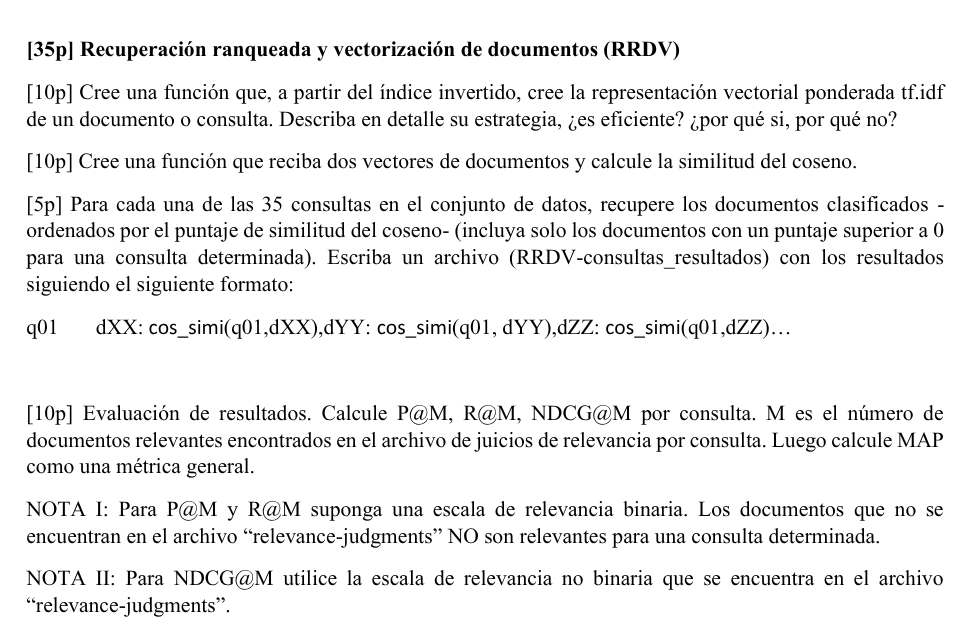

In [23]:
list_docs_files

['wes2015.d001.naf',
 'wes2015.d002.naf',
 'wes2015.d003.naf',
 'wes2015.d004.naf',
 'wes2015.d005.naf',
 'wes2015.d006.naf',
 'wes2015.d007.naf',
 'wes2015.d008.naf',
 'wes2015.d009.naf',
 'wes2015.d010.naf',
 'wes2015.d011.naf',
 'wes2015.d012.naf',
 'wes2015.d013.naf',
 'wes2015.d014.naf',
 'wes2015.d015.naf',
 'wes2015.d016.naf',
 'wes2015.d017.naf',
 'wes2015.d018.naf',
 'wes2015.d019.naf',
 'wes2015.d020.naf',
 'wes2015.d021.naf',
 'wes2015.d022.naf',
 'wes2015.d023.naf',
 'wes2015.d024.naf',
 'wes2015.d025.naf',
 'wes2015.d026.naf',
 'wes2015.d027.naf',
 'wes2015.d028.naf',
 'wes2015.d029.naf',
 'wes2015.d030.naf',
 'wes2015.d031.naf',
 'wes2015.d032.naf',
 'wes2015.d033.naf',
 'wes2015.d034.naf',
 'wes2015.d035.naf',
 'wes2015.d036.naf',
 'wes2015.d037.naf',
 'wes2015.d038.naf',
 'wes2015.d039.naf',
 'wes2015.d040.naf',
 'wes2015.d041.naf',
 'wes2015.d042.naf',
 'wes2015.d043.naf',
 'wes2015.d044.naf',
 'wes2015.d045.naf',
 'wes2015.d046.naf',
 'wes2015.d047.naf',
 'wes2015.d04

In [76]:
text = get_content_and_title('wes2015.d311.naf')
tokens = process_text_stop_words(text)
vector_tf_idf = inverted_index.create_tf_idf(1,tokens )

6 50 331
13 1 331
3 60 331
12 6 331
4 12 331
1 66 331
1 36 331
1 313 331
1 52 331
1 21 331
1 9 331
1 49 331
3 90 331
3 15 331
2 271 331
5 278 331
4 248 331
1 109 331
3 225 331
2 136 331
5 1 331
1 112 331
2 117 331
1 1 331
1 7 331
1 33 331
1 50 331
1 2 331
2 33 331
1 88 331
1 10 331
2 52 331
1 39 331
1 58 331
1 1 331
1 178 331
1 56 331
1 1 331
1 13 331
1 17 331
2 6 331
2 1 331
1 24 331
1 11 331
2 158 331
1 4 331
1 46 331
1 12 331
2 210 331
3 4 331
2 59 331
5 306 331
1 4 331
4 9 331
1 24 331
2 265 331
1 67 331
1 75 331
1 4 331
1 1 331
1 120 331
1 2 331
5 33 331
5 14 331
1 2 331
1 70 331
1 14 331
1 8 331
1 41 331
1 18 331
1 53 331
1 3 331
1 13 331
1 62 331
1 26 331
4 2 331
1 3 331
2 141 331
1 2 331
1 7 331
1 3 331
3 41 331
1 16 331
1 95 331
2 81 331
1 133 331
1 28 331
1 5 331
1 96 331
1 3 331
2 8 331
1 35 331
1 7 331
1 2 331
1 173 331
1 25 331
1 36 331
3 93 331
1 21 331
1 98 331
2 97 331
1 288 331
1 122 331
1 35 331
1 47 331
1 55 331
1 57 331
3 99 331
2 91 331
1 29 331
1 35 331
1 1 331
1 

In [77]:
len(set(tokens))

242

In [78]:
np.count_nonzero(vector_tf_idf)

179

In [73]:
vector_tf_idf

array([0.69370548, 2.88804551, 0.44653389, ..., 0.        , 0.        ,
       0.        ], shape=(13575,))

In [66]:
inverted_index.get("distant")

['distant', 5, [[199, 1], [234, 3], [284, 1], [289, 3], [311, 1]]]

In [61]:
tokens

['el',
 'escori',
 'the',
 'world',
 'largest',
 'renaiss',
 'build',
 'el',
 'escori',
 'the',
 'world',
 'largest',
 'renaiss',
 'build',
 'a',
 'distant',
 'view',
 'royal',
 'seat',
 'san',
 'lorenzo',
 'de',
 'el',
 'escori',
 'imag',
 'ecemaml',
 'on',
 'septemb',
 '13',
 '1584',
 'royal',
 'site',
 'san',
 'lorenzo',
 'de',
 'el',
 'escori',
 '45',
 'kilomet',
 'northwest',
 'spanish',
 'capit',
 'madrid',
 'finish',
 'el',
 'escori',
 'world',
 'largest',
 'renaiss',
 'build',
 'philip',
 'ii',
 'spain',
 'appoint',
 'spanish',
 'architect',
 'juan',
 'bautista',
 'de',
 'toledo',
 'collabor',
 'design',
 'el',
 'escori',
 'the',
 'architect',
 'alreadi',
 'work',
 'st',
 'peter',
 'basilica',
 'rome',
 'particip',
 'sever',
 'project',
 'napl',
 'he',
 'announc',
 'architect',
 'royal',
 '1559',
 'togeth',
 'design',
 'el',
 'escori',
 'monument',
 'spain',
 'role',
 'center',
 'christian',
 'world',
 'the',
 'build',
 'cornerston',
 'laid',
 '23',
 'april',
 '1563',
 'unfortu

42

In [54]:
list(vector_tf_idf)

[np.float64(0.6387516708699063),
 np.float64(2.806945642623135),
 np.float64(0.35386973840361996),
 np.float64(1.879584878146029),
 np.float64(0.8673557684438333),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.2698528559378082),
 np.float64(0.6411253568825265),
 np.float64(0.026147074957761297),
 np.float64(0.0529701821351537),
 np.float64(0.07548406188710935),
 np.float64(0.0),
 np.float64(0.07998721969705228),
 np.float64(0.11628460170466129),
 np.float64(1.7612841837354358),
 np.float64(0.0),
 np.float64(0.1359578290465288),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.3014255653031476),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.2419753309465222),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.5242969425113733),
 np

In [22]:
document

'wes2015.q46.naf'

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.17025819589739535),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.022813015722488728),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.16219977300620028),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.023839467489470852)

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float6

In [ ]:
list_query_files

['wes2015.q01.naf',
 'wes2015.q02.naf',
 'wes2015.q03.naf',
 'wes2015.q04.naf',
 'wes2015.q06.naf',
 'wes2015.q07.naf',
 'wes2015.q08.naf',
 'wes2015.q09.naf',
 'wes2015.q10.naf',
 'wes2015.q12.naf',
 'wes2015.q13.naf',
 'wes2015.q14.naf',
 'wes2015.q16.naf',
 'wes2015.q17.naf',
 'wes2015.q18.naf',
 'wes2015.q19.naf',
 'wes2015.q22.naf',
 'wes2015.q23.naf',
 'wes2015.q24.naf',
 'wes2015.q25.naf',
 'wes2015.q26.naf',
 'wes2015.q27.naf',
 'wes2015.q28.naf',
 'wes2015.q29.naf',
 'wes2015.q32.naf',
 'wes2015.q34.naf',
 'wes2015.q36.naf',
 'wes2015.q37.naf',
 'wes2015.q38.naf',
 'wes2015.q40.naf',
 'wes2015.q41.naf',
 'wes2015.q42.naf',
 'wes2015.q44.naf',
 'wes2015.q45.naf',
 'wes2015.q46.naf']

In [ ]:
inverted_index.num_elements

13575

In [ ]:
# print(document)
# print(index)
# print(tokens)
# print(tokens_set)

In [ ]:
inverted_index.length

32000

In [ ]:
for documnet in list_docs_files:
    print(documnet)
    tree = ET.parse(f"./data/docs-raw-texts/{documnet}")
    root = tree.getroot()
    file_desc = root.find(".//fileDesc")
    element_raw = root.find("raw")
    if file_desc is not None:
        title = file_desc.attrib.get("title")
    text = f"{title}\n {element_raw.text}"
    text = text.lower().strip(string.punctuation)
    stop_words = set(stopwords.words("english"))
    new_text = [
        word
        for word in word_tokenize(text)
        if word not in stop_words and word.isalpha()
    ]
    stemmer = PorterStemmer()
    singles = [stemmer.stem(word) for word in new_text]
    print(singles)

....

..                                                                                       [100%]


<ExitCode.OK: 0>

In [ ]:
word = "merry chirsmas"

hash(word)

6606879810003452448

In [ ]:
a = "Tu código: está usando split(), lo cual no elimina signos ni maneja casos especiales."

In [ ]:
class 

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

stemmer = 
text = "Hello w."
tokens = word_tokenize(text)    # ['Hello', 'w', '.']
tokens = [t for t in tokens if t.isalpha()]  # ['Hello', 'w']
stems = [stemmer.stem(t) for t in tokens]
print(stems)  # ['hello', 'w']

SyntaxError: invalid syntax (3969530359.py, line 7)

In [ ]:
import string

In [ ]:
text

'space invaders!\n space invaders!.\n\nspace invaders image:\xa0 adlen in early june 1978 – we have not been able to determine the exact date – the famous arcade video game space invaders designed by tomohiro nishikado was released by the japanese taito corporation. space invaders is one of the earliest shooting games and the aim is to defeat waves of attacking aliens with a laser cannon to earn as many points as possible. as the invaders were shot down one by one, their march grew faster and faster, until a lone invader sped across the screen. if you managed to hit them all, a new wave of invaders would take to the sky. but if the aliens were able to hit ground zero, it was game over for you and for the earth. with the inspiration of atari’s game breakout, tomohiro nishikado spent one year planning, designing and developing the needed hardware for the game. if you believe it or not, the game was in the sense of its graphics alot more advanced than breakout. also the game play was a bi

wes2015.d032.naf
['samuel', 'alderson', 'crash', 'test', 'dummi', 'samuel', 'alderson', 'crash', 'test', 'dummi', 'hybrid', 'iii', 'crash', 'test', 'dummi', 'famili', 'octob', 'engin', 'samuel', 'alderson', 'born', 'best', 'known', 'develop', 'crash', 'test', 'dummi', 'devic', 'last', 'half', 'twentieth', 'centuri', 'wide', 'use', 'automobil', 'manufactur', 'test', 'reliabl', 'automobil', 'seat', 'belt', 'safeti', 'protocol', 'samuel', 'alderson', 'attend', 'sever', 'colleg', 'includ', 'reed', 'colleg', 'california', 'institut', 'technolog', 'univers', 'california', 'berkeley', 'howev', 'higher', 'educ', 'interrupt', 'period', 'work', 'famili', 'busi', 'alderson', 'start', 'phd', 'physic', 'univers', 'berkeley', 'robert', 'oppenheim', 'lawrenc', 'never', 'finish', 'dissert', 'began', 'develop', 'electr', 'motor', 'missil', 'guidanc', 'system', 'world', 'war', 'ii', 'continu', 'career', 'ibm', 'order', 'design', 'prosthet', 'arm', 'alderson', 'found', 'compani', 'order', 'creat', 'anthr

In [ ]:
import nltk

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/erich/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Buscar el tag fileDesc dentro del header
file_desc = root.find(".//fileDesc")
if file_desc is not None:
    title = file_desc.attrib.get("title")
    print("->", title)

-> The psychologist must study mankind from the historical or comparative standpoint – Moritz Lazarus


Queries

In [ ]:
list_query_files = os.listdir("./data/queries-raw-texts/")
for query in list_query_files:
    tree = ET.parse(f"./data/docs-raw-texts/{query}")
    root = tree.getroot()
    element_raw = root.find("raw")
    element

In [ ]:
tree = ET.parse("./data/queries-raw-texts/wes2015.q01.naf")

In [ ]:
root = tree.getroot()

In [ ]:
file_desc.attrib.get("title")

In [ ]:
file_desc.

<Element 'fileDesc' at 0x771a9db909a0>

In [ ]:
element = root.find("nafHeader").find("fileDesc")
if element is not None:
    print(element.text)

None


['wes2015.q03.naf',
 'wes2015.q13.naf',
 'wes2015.q37.naf',
 'wes2015.q08.naf',
 'wes2015.q41.naf',
 'wes2015.q14.naf',
 'wes2015.q32.naf',
 'wes2015.q44.naf',
 'wes2015.q22.naf',
 'wes2015.q24.naf',
 'wes2015.q25.naf',
 'wes2015.q16.naf',
 'wes2015.q45.naf',
 'wes2015.q23.naf',
 'wes2015.q10.naf',
 'wes2015.q01.naf',
 'wes2015.q29.naf',
 'wes2015.q02.naf',
 'wes2015.q07.naf',
 'wes2015.q28.naf',
 'wes2015.q04.naf',
 'wes2015.q34.naf',
 'wes2015.q17.naf',
 'wes2015.q12.naf',
 'wes2015.q42.naf',
 'wes2015.q06.naf',
 'wes2015.q09.naf',
 'wes2015.q46.naf',
 'wes2015.q27.naf',
 'wes2015.q36.naf',
 'wes2015.q18.naf',
 'wes2015.q26.naf',
 'wes2015.q40.naf',
 'wes2015.q19.naf',
 'wes2015.q38.naf']